In [1]:
#### Import necessary packages 

import pandas as pd                   # panda is a package for data analysis and manipulation
import matplotlib.pyplot as plt       # matplotlib is the OG python plotting library and really useful for formatting
import numpy as np                    # numpy is used to perform a wide variety of mathematical operations on arrays
import seaborn as sns                 # seaborn is a package for data visualization 

In [2]:
## Import CTD sensor data as a dataframe

## This data was extracted from the 2021 GEOTRACES IDP webODV tool and downloaded as a txt file:  https://geotraces.webodv.awi.de/login
sensor = pd.read_csv("C:/Users/nicol/OEAS_895/capstone_project/raw_data/IDP2021_sensors.txt", sep = '\t', skiprows = 25, low_memory = False)


# print labels of columns from the imported dataframe 

print(sensor.columns)

Index(['Cruise', 'Station', 'Type', 'yyyy-mm-ddThh:mm:ss.sss',
       'Longitude [degrees_east]', 'Latitude [degrees_north]',
       'CTDPRS_T_VALUE_SENSOR [dbar]', 'QV:SEADATANET',
       'CTDTMP_T_VALUE_SENSOR [deg C]', 'QV:SEADATANET.1',
       'CTDSAL_D_CONC_SENSOR [pss-78]', 'QV:SEADATANET.2',
       'CTDOXY_D_CONC_SENSOR [umol/kg]', 'QV:SEADATANET.3',
       'CTDCHLA_T_CONC_SENSOR [mg/m^3]', 'QV:SEADATANET.4',
       'CTDFLUOR_T_VALUE_SENSOR [arbitrary units]', 'QV:SEADATANET.5',
       'CTDBEAMCP_T_VALUE_SENSOR [1/m]', 'QV:SEADATANET.6',
       'CTDPAR_T_VALUE_SENSOR [arbitrary units]', 'QV:SEADATANET.7',
       'QV:ODV:SAMPLE'],
      dtype='object')


In [3]:
# Since I only care about phytoplankton biomass in the surface waters, remove all data below 150 db

sensor_150 = sensor[(sensor['CTDPRS_T_VALUE_SENSOR [dbar]']<150)]

In [4]:
# Create a new dataframe for each cruise

GA02 = sensor_150[sensor_150['Cruise'].str.contains('GA02')]  # filtering the rows to pull specifically the GA02 cruise

GA03 = sensor_150[sensor_150['Cruise'].str.contains('GA03')]  # filtering the rows to pull specifically the GA03 cruise

GA10 = sensor_150[sensor_150['Cruise'].str.contains('GA10')]  # filtering the rows to pull specifically the GA10 cruise

GIPY5 = sensor_150[sensor_150['Cruise'].str.contains('GIPY5')]  # filtering the rows to pull specifically the GIPY5 cruise

In [5]:
# Find the minimum beam attenuation values 

GA02_beamcp_min = min(GA02['CTDBEAMCP_T_VALUE_SENSOR [1/m]'])
GA03_beamcp_min = min(GA03['CTDBEAMCP_T_VALUE_SENSOR [1/m]'])
GA10_beamcp_min = min(GA10['CTDBEAMCP_T_VALUE_SENSOR [1/m]'])
GIPY5_beamcp_min = min(GIPY5['CTDBEAMCP_T_VALUE_SENSOR [1/m]'])

l1 = ['GA02','GA03','GA10','GIPY5']
l2 = [GA02_beamcp_min, GA03_beamcp_min, GA10_beamcp_min, GIPY5_beamcp_min]

cruise_beamcp_min = pd.DataFrame(list(zip(l1, l2))) 
cruise_beamcp_min.columns = ['Cruise','Minimum Beam cp']

# print dataframe that displays the minimum beam attenuation valeus calculated for each cruise
cruise_beamcp_min

,Cruise,Minimum Beam cp
0,GA02,0.034000
1,GA03,0.014707
2,GA10,-0.053090
3,GIPY5,0.051940


In [6]:
#### For loop that steps through the minimum beam cp table to pulls values where a negative beam attenuation value found 

# Create an empty list
BeamCP_list = []
cruise_list = []


# print only the negative values from the beam cp minimums calculated

for i, row in cruise_beamcp_min.iterrows():      # Initialize for loop
    if row['Minimum Beam cp'] < 0:               
        BeamCP_list.append(row['Minimum Beam cp'])
        cruise_list.append(row['Cruise'])
        print('Index', i, '- Cruise:', row['Cruise'], '- Minimum Beam cp:', row['Minimum Beam cp'])


# changes the cruise list to a string so I can use it in the for loop for 'in' statement
cruise_list = ''.join(cruise_list)


Index 2 - Cruise: GA10 - Minimum Beam cp: -0.05309


In [7]:
# For loop that applies the absolute value of the minimum beam attenuation only to cruises that indicated 
# a negative beam attenuation value in the previous cell

# create the variable called offset that looks at the original beam attenuation data and applies the offset to necessary cruises
for index, row in sensor_150.iterrows():
    if cruise_list in row['Cruise']:
        offset = sensor_150['CTDBEAMCP_T_VALUE_SENSOR [1/m]'] + np.abs(BeamCP_list) # this creates a list with as many rows as sensor_150

# This coverts the new variable 'offset' to a dataframe so we can replace the previous column
offset = pd.DataFrame(offset)

In [8]:
# repalce rows where cruise needs offset applied

sensor_150['CTDBEAMCP_T_VALUE_SENSOR [1/m]'] = offset['CTDBEAMCP_T_VALUE_SENSOR [1/m]']

### check that it replaced ['CTDBEAMCP_T_VALUE_SENSOR [1/m]'] column with updated column 
### (if there were negative beam cp before, then the new minumum for beam cp should be zero)
sensor_150.describe()

C:\Users\nicol\AppData\Local\Temp\ipykernel_22276\2562659864.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sensor_150['CTDBEAMCP_T_VALUE_SENSOR [1/m]'] = offset['CTDBEAMCP_T_VALUE_SENSOR [1/m]']


,Longitude [degrees_east],Latitude [degrees_north],CTDPRS_T_VALUE_SENSOR [dbar],QV:SEADATANET,CTDTMP_T_VALUE_SENSOR [deg C],QV:SEADATANET.1,CTDSAL_D_CONC_SENSOR [pss-78],QV:SEADATANET.2,CTDOXY_D_CONC_SENSOR [umol/kg],QV:SEADATANET.3,CTDCHLA_T_CONC_SENSOR [mg/m^3],QV:SEADATANET.4,CTDFLUOR_T_VALUE_SENSOR [arbitrary units],QV:SEADATANET.5,CTDBEAMCP_T_VALUE_SENSOR [1/m],QV:SEADATANET.6,CTDPAR_T_VALUE_SENSOR [arbitrary units],QV:SEADATANET.7,QV:ODV:SAMPLE
count,114809.000000,114809.000000,114809.000000,114809.000000,114717.000000,114809.000000,114678.000000,114809.000000,86699.000000,114809.000000,23554.000000,114809.000000,90853.000000,114809.000000,67817.000000,114809.000000,1173.000000,114809.000000,114809.0
mean,271.852794,-9.609963,76.170087,0.512817,15.709658,0.515587,35.402920,0.518156,199.038685,2.630917,0.130561,7.320454,0.404461,1.881821,0.149168,3.865037,0.004147,8.908047,1.0
std,80.206900,37.445259,42.168642,0.499838,10.089875,0.554487,1.117726,0.578308,53.667130,3.655826,0.216123,3.310607,1.005118,3.656777,0.073597,4.296370,0.014697,0.905056,0.0
min,0.000000,-70.574900,0.000000,0.000000,-1.870000,0.000000,28.455000,0.000000,-5.118000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,237.499600,-44.660400,40.000000,0.000000,5.446000,0.000000,34.469002,0.000000,194.200000,0.000000,0.030000,9.000000,0.033000,0.000000,0.108090,0.000000,0.000000,9.000000,1.0
50%,296.242610,-11.670600,76.000000,1.000000,18.899900,1.000000,35.547001,1.000000,207.300000,1.000000,0.060000,9.000000,0.066000,0.000000,0.129090,1.000000,0.000000,9.000000,1.0
75%,320.569000,24.000000,113.000000,1.000000,24.097000,1.000000,36.252800,1.000000,221.800000,1.000000,0.130000,9.000000,0.250000,0.000000,0.168090,9.000000,0.001000,9.000000,1.0
max,359.999910,64.000300,149.910000,1.000000,30.021600,9.000000,37.638000,9.000000,387.301000,9.000000,2.340000,9.000000,10.000000,9.000000,3.185377,9.000000,0.174000,9.000000,1.0


In [9]:
######## Because not all cruises using the same CTD biological sensors, I want to look at the range of any and 
######## all biologcial sensors available against beam attenuatin data. 

######## Scatterplots created below just for initial exploratory data analysis


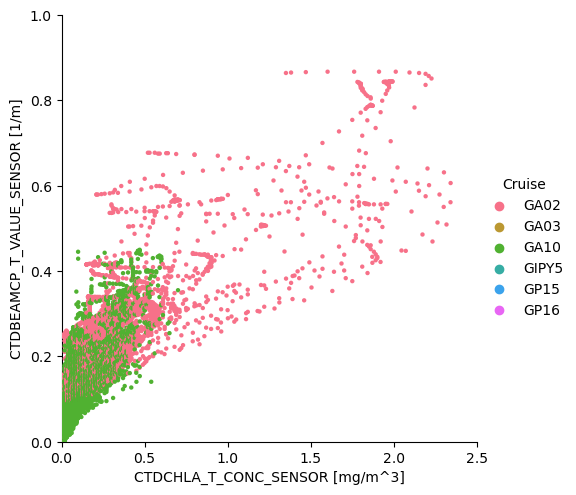

In [10]:
# This creates a categorical scatterplot for chlorophyll sensor data vs beam attenuation for cruises that had both variables

sns.color_palette("husl", 9)

g = sns.catplot(x = 'CTDCHLA_T_CONC_SENSOR [mg/m^3]', y = 'CTDBEAMCP_T_VALUE_SENSOR [1/m]', hue = 'Cruise', data = sensor_150, native_scale=True, palette = 'husl', s = 10)

g.set(xlim=(0,2.5), ylim=(0,1))

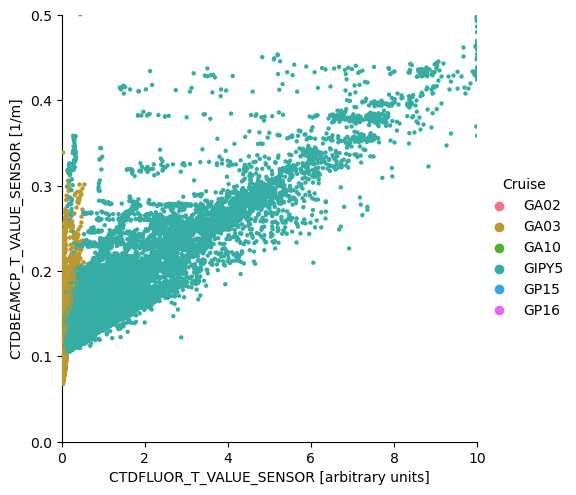

In [11]:
# This creates a categorical scatterplot for fluorescence sensor data vs beam attenuation for cruises that had both variables

h = sns.catplot(x = 'CTDFLUOR_T_VALUE_SENSOR [arbitrary units]', y = 'CTDBEAMCP_T_VALUE_SENSOR [1/m]', hue = 'Cruise', data = sensor_150, native_scale=True, palette = 'husl', s = 10)

h.set(xlim=(0,10), ylim=(0,0.5))

In [12]:
######## This shows that though both have fluorescence but the scales vary greatly, so before any models 
######## are applied, the data should be normalized or scaled. 

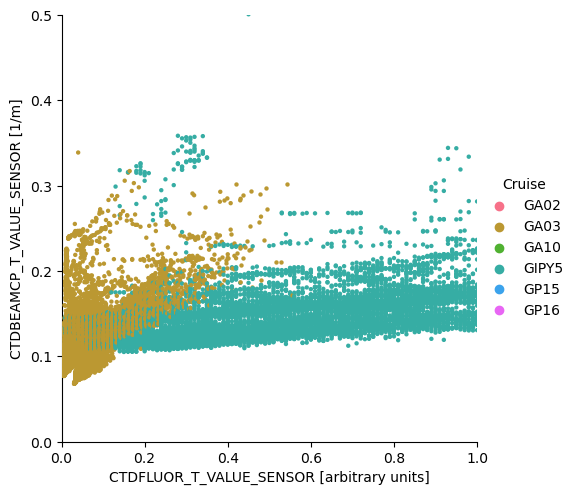

In [13]:
# This creates a categorical scatterplot for fluorescence sensor data vs beam attenuation for cruises that had both variables
# To zoom in on the cruise that covered a much narrow range of values

i = sns.catplot(x = 'CTDFLUOR_T_VALUE_SENSOR [arbitrary units]', y = 'CTDBEAMCP_T_VALUE_SENSOR [1/m]', hue = 'Cruise', data = sensor_150, native_scale=True, palette = 'husl', s = 10)

i.set(xlim=(0,1), ylim=(0,0.5))

C:\Users\nicol\AppData\Local\Temp\ipykernel_22276\3615832631.py:9: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = sensor_150.corr(method='pearson')


<AxesSubplot: >

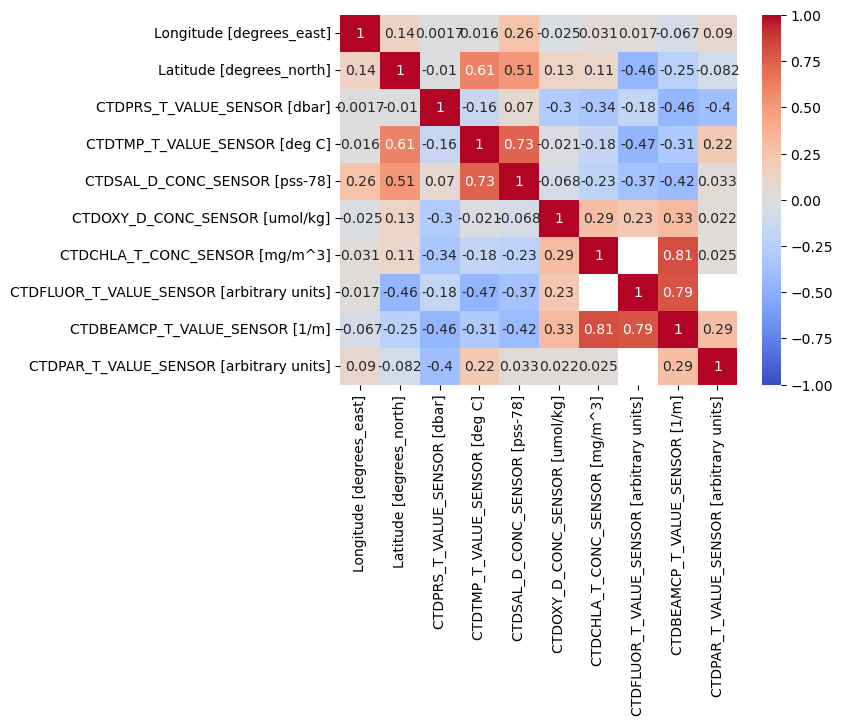

In [14]:
####### Make a correlation heat map to look at the correlation of other imported parameters with beam attenuation.
####### Gives a rough idea of the correlation between beam attenuation and chlorophyll fluorescence and other potnetial 
####### paramters to consider in future models.


### Create a new dataframe that doesn't have the data flag columns (so they don't show up in the matrix)
sensor_150 = sensor_150.drop(['QV:SEADATANET', 'QV:SEADATANET.1', 'QV:SEADATANET.2', 'QV:SEADATANET.3', 'QV:SEADATANET.4', 'QV:SEADATANET.5', 'QV:SEADATANET.6', 'QV:SEADATANET.7', 'QV:ODV:SAMPLE'], axis=1)

correlation = sensor_150.corr(method='pearson')

import matplotlib.colors as colors
from matplotlib import cm
cmap = cm.coolwarm

sns.heatmap(correlation, annot=True, norm=colors.CenteredNorm(), cmap=cmap)

In [15]:
######## This project applies the model to raw, normalized, and standardized data to compare 
######## and evaluate their results and select the technique with the best outcome.

In [16]:
#########  Because the the biological sensor data cover a large range and have different units, the data should be normalized. 
#########  However, because normalization is highly affected by outliers, the beam attenuatino outliers in the GIPY5 dataset 
#########  will be removed first. 

In [17]:
## Create new variables that split the dataset into those that have chlorophypll and beam attenuation 
## and those that have fluorescence and beam attenuation.
## Drops all rows that have a NaN in either fluorescence/chl or beam attenuation

chl_150 = sensor_150.dropna(subset=['CTDCHLA_T_CONC_SENSOR [mg/m^3]','CTDBEAMCP_T_VALUE_SENSOR [1/m]'])

flu_150 = sensor_150.dropna(subset=['CTDFLUOR_T_VALUE_SENSOR [arbitrary units]','CTDBEAMCP_T_VALUE_SENSOR [1/m]'])

## Removes the datapoints in the fluorescence subset that had beamcp data greater than 0.4 (outliers seen in the categorical scatterplot for the one cruise)
flu_150 = flu_150[(flu_150['CTDBEAMCP_T_VALUE_SENSOR [1/m]']<0.4)]



In [18]:
# Normalize chlorophyll dataset

chl_min = min(chl_150['CTDCHLA_T_CONC_SENSOR [mg/m^3]'])
chl_max = max(chl_150['CTDCHLA_T_CONC_SENSOR [mg/m^3]'])
chl_range = chl_max - chl_min
chl_normalized = (chl_150['CTDCHLA_T_CONC_SENSOR [mg/m^3]'] - chl_min)/chl_range

In [19]:
# Normalize fluorescence dataset

flu_min = min(flu_150['CTDFLUOR_T_VALUE_SENSOR [arbitrary units]'])
flu_max = max(flu_150['CTDFLUOR_T_VALUE_SENSOR [arbitrary units]'])
flu_range = flu_max - flu_min

flu_normalized = (flu_150['CTDFLUOR_T_VALUE_SENSOR [arbitrary units]'] - flu_min)/flu_range

In [20]:
# Split up predictor and target variables

chl_flu = pd.concat([chl_normalized, flu_normalized], axis = 0)
beamcp = pd.concat([chl_150['CTDBEAMCP_T_VALUE_SENSOR [1/m]'], flu_150['CTDBEAMCP_T_VALUE_SENSOR [1/m]']], axis = 0)


# X = pd.DataFrame(chl_flu)

# beamcp = pd.concat([beam_chl_normalized, beam_flu_normalized], axis = 0)
# y = pd.DataFrame(beamcp)

mod_sensor = pd.concat([sensor_150['Cruise'], chl_flu, beamcp], axis = 1)


# make the dataframe first then add columns

# adding column name to the respective columns
mod_sensor.columns =['Cruise', 'Normalized Chlorohyll Fluorescence', 'Beam Attenuation [1/m]']



# Because this pulls cruises that had no data, drop all rows that have a NaN in BOTH fluorescence/chl AND beam attenuation
mod_sensor = mod_sensor.dropna(subset=['Normalized Chlorohyll Fluorescence','Beam Attenuation [1/m]'], how='all')


mod_sensor

,Cruise,Normalized Chlorohyll Fluorescence,Beam Attenuation [1/m]
0,GA02,0.017094,0.12109
1,GA02,0.017094,0.12109
2,GA02,0.017094,0.12109
3,GA02,0.017094,0.12209
4,GA02,0.017094,0.12209
...,...,...,...
1558043,GIPY5,0.025000,0.15600
1558044,GIPY5,0.019000,0.15436
1558045,GIPY5,0.017000,0.15272
1558046,GIPY5,0.019000,0.15436


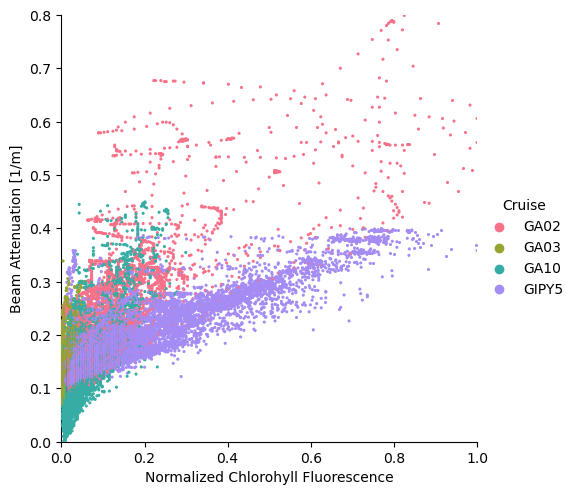

In [21]:
j = sns.catplot(x = 'Normalized Chlorohyll Fluorescence', y = 'Beam Attenuation [1/m]', hue = 'Cruise', data = mod_sensor, native_scale=True, palette = 'husl', s = 5)

j.set(xlim=(0,1), ylim=(0,0.8))

In [22]:
# Split up predictor and target variables

# predictor variable
X = pd.DataFrame(mod_sensor['Normalized Chlorohyll Fluorescence'])

# target variable
y = pd.DataFrame(mod_sensor['Beam Attenuation [1/m]'])

In [23]:
# Split the dataset into a 70% train and a 30% test 

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.7, random_state=5)

In [24]:
# Import the necessary modules and libraries
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score

## FOR LOOP
scores = {}
MSE_list = []

# the number and range of nodes that will be itterated in the loop
k_range = range(1, 51, 1) # always have to go one beyond the number desired (just how python works)


for k in k_range:
#     print(k)
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train, y_train)
    
   # Make predictions using the testing set
    y_pred = knn.predict(X_test)
    scores[k] = r2_score(y_test,y_pred)
    MSE_list.append(mean_squared_error(y_test,y_pred))
#     print('r2 =', scores[k])
#     print('MSE =', mean_squared_error(y_test, y_pred))

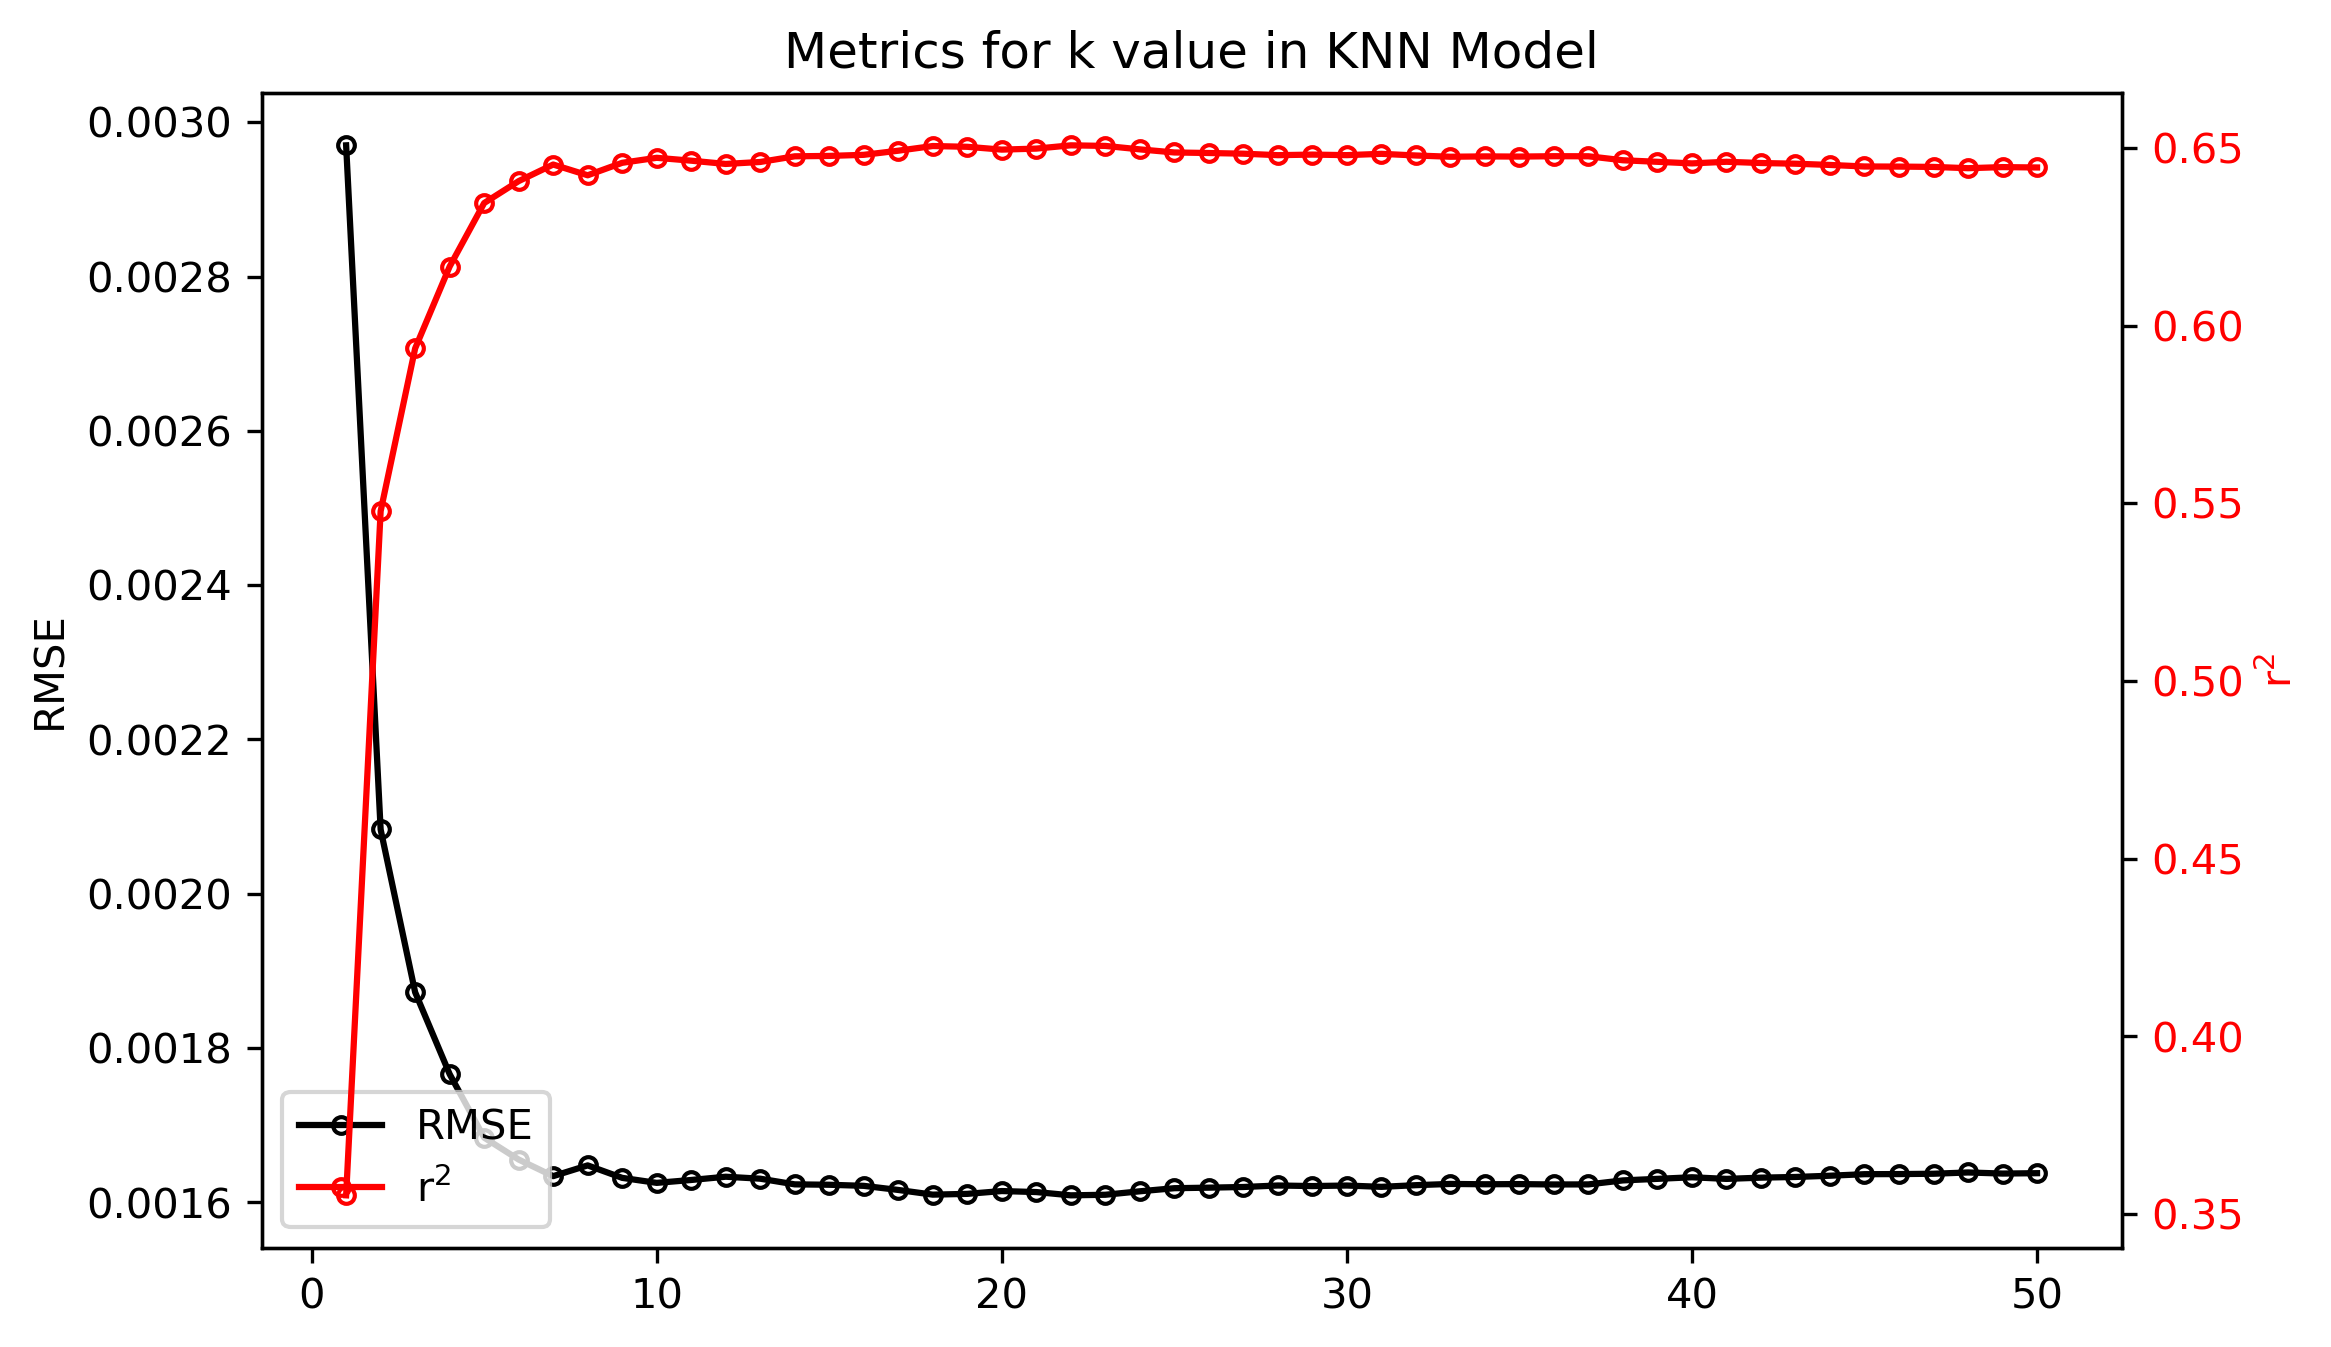

In [25]:
# because r^2 is a dictionary and not a list, separate them out and only get the r^2 values

r2_list = []

for a,b in scores.items():
#     print(a,'', b)
    r2_list.append(b)

# where k is the node and v is the r^2 values

fig, ax1 = plt.subplots(figsize = (8,5), dpi = 300, sharex = 'all')
ax2 = ax1.twinx() # twinx creates a new axes object ax2 that shares the same x-axis with ax1\

l1 = ax1.plot(k_range, MSE_list, 'o-k', markersize = 4 , markerfacecolor = 'none', label = 'RMSE')
ax1.set_ylabel(r'RMSE', color = 'k')
ax1.tick_params(axis='y', labelcolor = 'black')

l2 = ax2.plot(k_range, r2_list, 'o-r', markersize = 4, markerfacecolor = 'none', label = 'r$^{2}$')
ax2.set_ylabel(r'r$^{2}$', color = 'red')
ax2.tick_params(axis = 'y', labelcolor = 'red')
ax2.set_xlabel('# of nodes')


lns = l1 + l2
labs = [l.get_label() for l in lns]

plt.title('Metrics for k value in KNN Model')
ax1.legend(lns, labs, loc = 'lower left')

Choose a number for k: 10
r2 Train score: 0.68


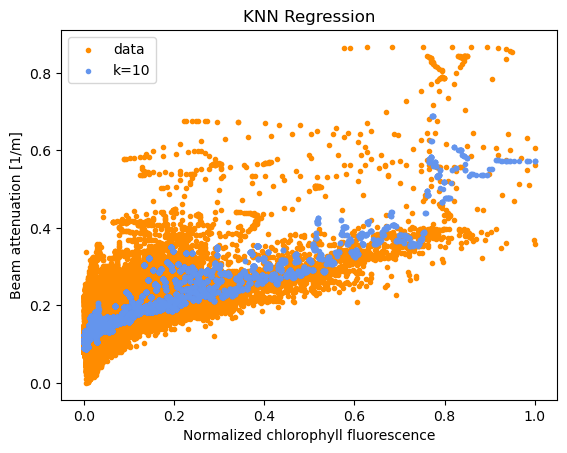

Accuracy Test Score:  0.6444871431278067


In [26]:
#### Pick a value for k based on the RMSE and r^2 

n  = int(input('Choose a number for k: '))


# Fit regression model
knn_final = KNeighborsRegressor(n_neighbors=n)
knn_final.fit(X_train, y_train)
print("r2 Train score: {0:.2f}".format(knn_final.score(X_train, y_train)))

# Predict
y_pred_final = knn_final.predict(X_test)

# Plot the results
plt.figure()
plt.scatter(X, y, marker = '.', c="darkorange", label="data")
plt.scatter(X_test, y_pred_final, marker = '.', color="cornflowerblue", label="k="+str(n))
plt.xlabel('Normalized chlorophyll fluorescence')
plt.ylabel('Beam attenuation [1/m]')
plt.title('KNN Regression')
plt.legend()
plt.show()


# print the score
print('Accuracy Test Score: ', knn.score(X_test, y_test))

r2 = 0.6788343198121882
r2 = 0.6472104863880547
MSE = 0.001625288792179263


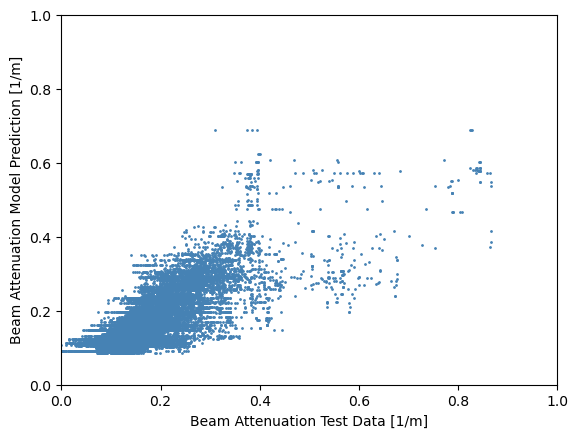

In [27]:
print('r2 =', r2_score(y_train, knn_final.predict(X_train))) # r2 between training datasets
print('r2 =', r2_score(y_test, y_pred_final)) # r2 between testing dataset and predicted value
print('MSE =',mean_squared_error(y_test, y_pred_final))

plt.plot(y_test, y_pred_final, 'o', markersize = 1, c='steelblue')
plt.xlabel('Beam Attenuation Test Data [1/m]')
plt.xlim([0, 1])
plt.ylabel('Beam Attenuation Model Prediction [1/m]')
plt.ylim([0, 1])

plt.show()

In [28]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True)

for train, test in kf.split(X):
    print("%s %s" % (train, test))

[    1     2     4 ... 67241 67243 67244] [    0     3    12 ... 67233 67237 67242]
[    0     1     2 ... 67238 67242 67243] [    6     8    14 ... 67240 67241 67244]
[    0     1     2 ... 67241 67242 67244] [    4     5     7 ... 67222 67223 67243]
[    0     3     4 ... 67242 67243 67244] [    1     2    10 ... 67227 67228 67236]
[    0     1     2 ... 67242 67243 67244] [    9    11    27 ... 67218 67234 67238]


In [29]:
from sklearn.model_selection import cross_validate

results = cross_validate(estimator=knn_final, X=X, y=y, cv=kf, return_train_score=True)

In [30]:
from sklearn.model_selection import cross_val_predict

y_pred_cv = cross_val_predict(knn_final, X, y, cv=kf)

#### ----Ignore everything below for now as I am trying to find better ways to display the model predicted values compared to the test values----

r2 = 0.6788343198121882
r2 = 0.6472104863880547
MSE = 0.001625288792179263


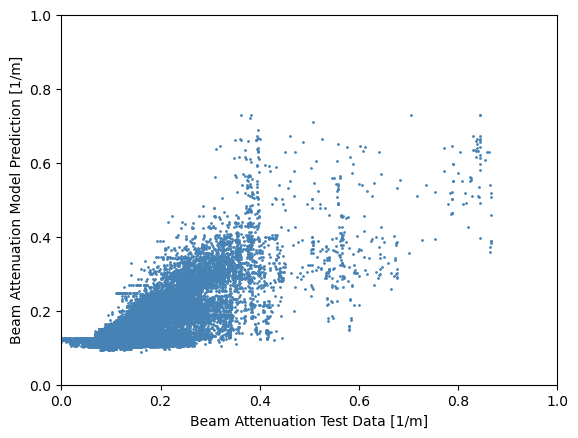

In [34]:
print('r2 =', r2_score(y_train, knn_final.predict(X_train))) # r2 between training datasets
print('r2 =', r2_score(y_test, y_pred_final)) # r2 between testing dataset and predicted value
print('MSE =',mean_squared_error(y_test, y_pred_final))


plt.plot(y, y_pred_cv, 'o', markersize = 1, c='steelblue')
plt.xlabel('Beam Attenuation Test Data [1/m]')
plt.xlim([0, 1])
plt.ylabel('Beam Attenuation Model Prediction [1/m]')
plt.ylim([0, 1])

plt.show()

In [ ]:
from sklearn.metrics import PredictionErrorDisplay

fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
PredictionErrorDisplay.from_predictions(
    y,
    y_pred=y_pred_cv,
    kind="actual_vs_predicted",
    subsample=100,
    ax=axs[0],
    random_state=0,
)
axs[0].set_title("Actual vs. Predicted values")
PredictionErrorDisplay.from_predictions(
    y,
    y_pred=y_pred_cv,
    kind="residual_vs_predicted",
    subsample=100,
    ax=axs[1],
    random_state=0,
)
axs[1].set_title("Residuals vs. Predicted Values")
fig.suptitle("Plotting cross-validated predictions")
plt.tight_layout()
plt.show()